In [1]:
import xarray 
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/scripts")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance
import imp
imp.reload(utils)
from netrep.utils import align

import scipy.stats as sts
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_24119/835707921.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
files = glob.glob('../data/*')
subs = [xarray.load_dataarray(file) for file in files]

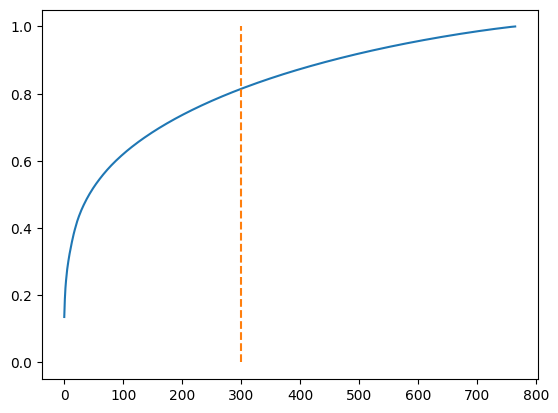

In [3]:

pca = PCA()
pcs_1 = pca.fit(subs[0][:,:,0])  
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.plot([300,300],[0,1],'--')  

In [4]:
np.shape(subs[0])

(766, 13039, 2)

In [5]:


pca = PCA(n_components=766)
low_subs = [[pca.fit_transform(sub[:,:,0]),pca.fit_transform(sub[:,:,1])] for sub in subs]

distances  = np.zeros((2,len(low_subs),len(low_subs)))
for i in range(len(low_subs)):
    sub_i = low_subs[i]
    for j in range(len(low_subs)):
        sub_j = low_subs[j]
        distances[0,i,j] = utils.dsd([[sub_i[0],sub_j[1]]],alpha=0)
        distances[1,i,j] = utils.dsd([[sub_i[0],sub_j[1]]],alpha=1)

same_0 = np.diag(distances[0])
different_0 = distances[0][np.tril_indices(8,k=1)]

same_1 = np.diag(distances[1])
different_1 = distances[1][np.tril_indices(8,k=1)]


2025-01-24 18:40:21,049	INFO worker.py:1788 -- Started a local Ray instance.


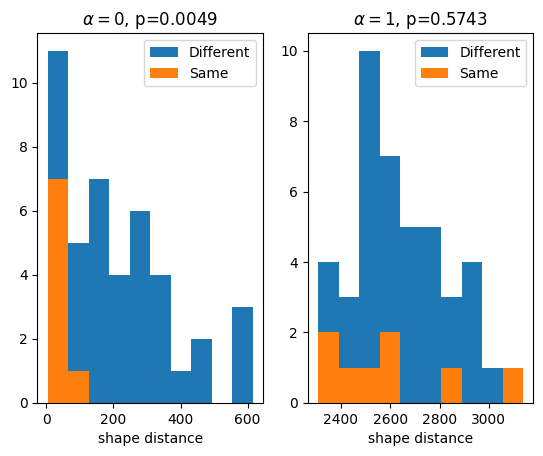

In [6]:
plt.subplot(1,2,1)  
plt.title(r'$\alpha=0$'', p=%.4f'%sts.ttest_ind(same_0,different_0)[1])
x=plt.hist(different_0,bins=10,label='Different')
plt.hist(same_0,bins=x[1],label='Same')
plt.xlabel('shape distance')
plt.legend()

plt.subplot(1,2,2)  
plt.title(r'$\alpha=1$'', p=%.4f'%sts.ttest_ind(same_1,different_1)[1])
x=plt.hist(different_1,bins=10,label='Different')
plt.hist(same_1,bins=x[1],label='Same')
plt.xlabel('shape distance')
plt.legend()

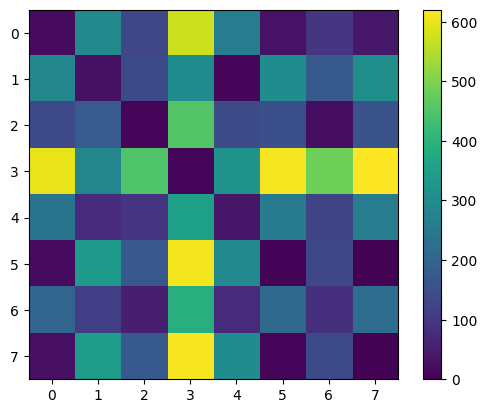

In [7]:
plt.imshow(distances[0],vmin=0)
plt.colorbar()

(array([11.,  4., 12.,  5.,  8.,  7.,  0.,  3.,  0.,  6.]),
 array([-33.98256683,  30.57712193,  95.13681068, 159.69649944,
        224.2561882 , 288.81587696, 353.37556572, 417.93525448,
        482.49494324, 547.054632  , 611.61432076]),
 <BarContainer object of 10 artists>)

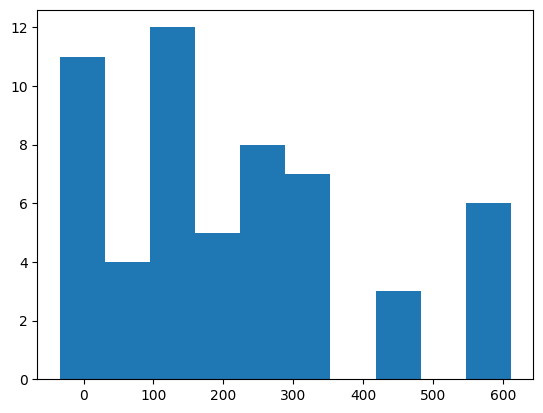

In [8]:
diffs = (distances[0] - np.diag(distances[0])[:,None])
diffs = diffs.reshape(-1)
diffs = diffs[diffs!=0]
sts.ttest_1samp(diffs,0)
plt.hist(diffs)

Text(0, 0.5, 'PC2')

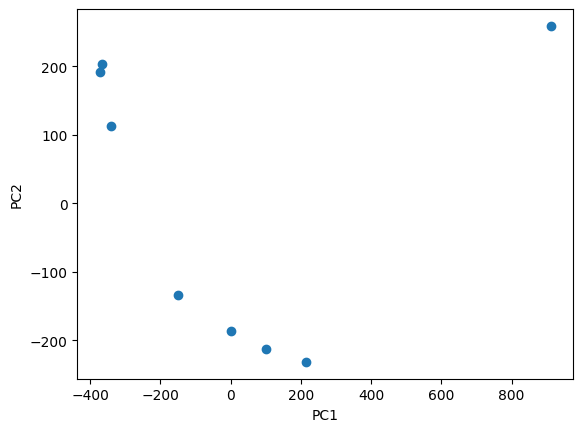

In [9]:
pca = PCA(n_components=2)
d = pca.fit_transform(distances[0])
plt.plot(d[:,0],d[:,1],'o')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [10]:
all_sub = np.reshape(low_subs,[16,766,766])


distances_all  = np.zeros((2,len(all_sub),len(all_sub)))
for i in tqdm.trange(len(all_sub)):
    sub_i = all_sub[i]
    for j in range(len(all_sub)):
        sub_j = all_sub[j]
        distances_all[0,i,j] = utils.dsd([[sub_i,sub_j]],alpha=0)
        distances_all[1,i,j] = utils.dsd([[sub_i,sub_j]],alpha=1)



100%|██████████| 16/16 [04:05<00:00, 15.34s/it]


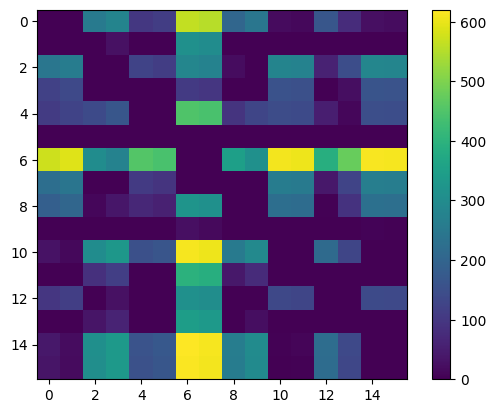

In [11]:
dist_c = distances_all.copy()
rows, cols = np.diag_indices(dist_c[0].shape[0])
superdiagonal_indices = (rows[:-1], cols[1:])
for i,j in enumerate(dist_c[0][superdiagonal_indices]):
    dist_c[0][i,:] -= j
dist_c[0][i+1,:] -= dist_c[0][i+1,i]    
plt.imshow(dist_c[0],vmin=0)

diffs = dist_c[0][np.tril_indices(16)].reshape(-1)[dist_c[0][np.tril_indices(16)].reshape(-1)!=0]
sts.ttest_1samp(diffs,0)
plt.colorbar()